In [12]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip


--2022-12-15 00:04:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.102, 52.217.68.102, 52.216.177.205, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  39.7MB/s    in 0.3s    

2022-12-15 00:04:54 (39.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
ls

drive/                      jena_climate_2009_2016.csv.zip    __MACOSX/
jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip.1  sample_data/


In [14]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
len(header)

15

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]] # Date Time 제외
  temperature[i] = values[1]
  raw_data[i,:] = values[:]

In [15]:
temperature[0]

-8.02

In [ ]:
raw_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

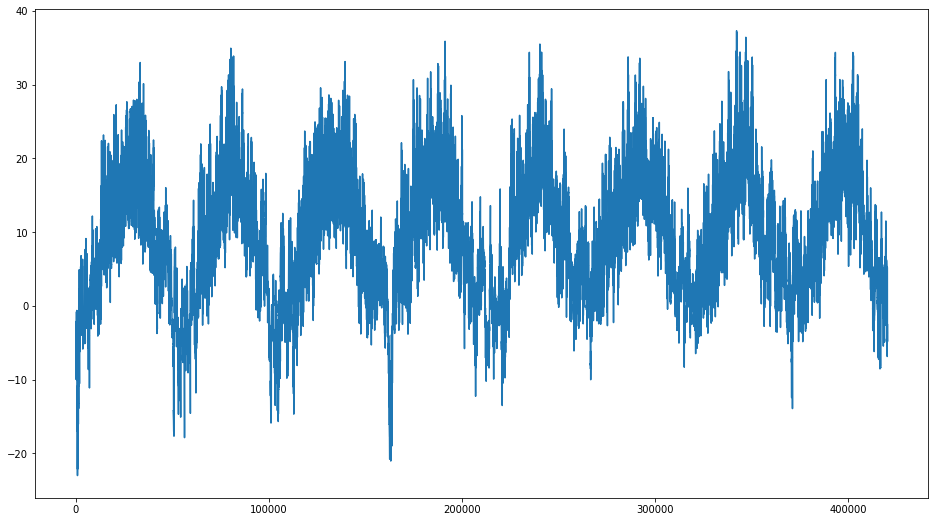

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(range(len(temperature)), temperature)
plt.show()

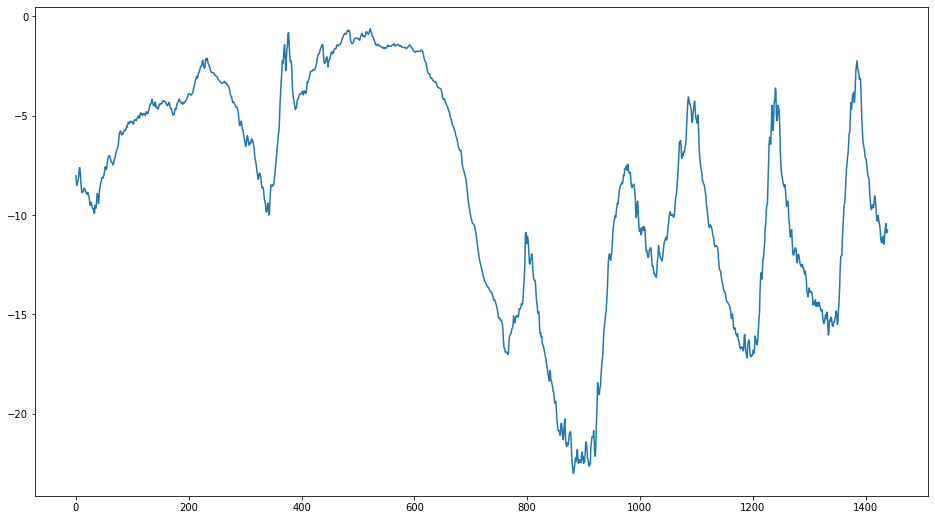

In [ ]:
# 처음 10일간의 기온을 그래프로 그려보기(6 * 24 * 10 = 1440)
plt.figure(figsize=(16,9))
plt.plot(range(1440), temperature[:1440])
plt.show()

In [16]:
len(raw_data)

420451

In [17]:
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples,num_val_samples,num_test_samples)

210225 105112 105114


In [18]:
# 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [19]:
from tensorflow import keras

sampling_rate = 6 # 10분에 1개 데이터, 시간당 6개
sequence_length = 120 # time-steps 
delay = sampling_rate * (sequence_length + 24 -1) # 24시간이 지난 데이터, 타겟으로 사용할 미래의 time-step
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,    
    start_index=num_train_samples + num_val_samples)


In [20]:
# 배치 크기 확인
for samples, targets in train_dataset:
  print(samples.shape, targets.shape)
  break

(256, 120, 14) (256,)


In [21]:
raw_data.shape

(420451, 14)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16,activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f'테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 12s 14ms/step - loss: 13.2159 - mae: 2.8210 - val_loss: 15.0388 - val_mae: 3.0921
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 9.5522 - mae: 2.4309 - val_loss: 11.2658 - val_mae: 2.6582
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 8.7202 - mae: 2.3247 - val_loss: 12.0138 - val_mae: 2.7589
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 8.2180 - mae: 2.2591 - val_loss: 9.9370 - val_mae: 2.4926
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 7.7731 - mae: 2.1957 - val_loss: 10.5557 - val_mae: 2.5831
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.5033 - mae: 2.1564 - val_loss: 11.0042 - val_mae: 2.6296
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 7.2664 - mae: 2.1238 - val_loss: 10.4550 - val_mae: 2.5552
Epoch 8/10
819/819 [==============================] - 1

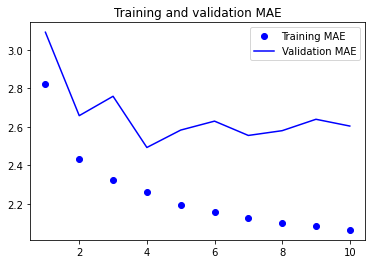

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training MAE')
plt.plot(epochs,val_loss,'b',label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

plt.show()

In [ ]:
# 상식 수준의 기준점
# 검증 MAE 2.44
# 테스트 MAE 2.62
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:,-1,1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f'검증 MAE: {evaluate_naive_method(val_dataset):.2f}')
print(f'테스트 MAE: {evaluate_naive_method(test_dataset):.2f}')

검증 MAE: 2.44
테스트 MAE: 2.62


[과제] 1D 합성곱 모델 시도

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 23s 15ms/step - loss: 23.5695 - mae: 3.8113 - val_loss: 17.3145 - val_mae: 3.3205
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 16.4469 - mae: 3.2265 - val_loss: 15.5162 - val_mae: 3.1221
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.9824 - mae: 3.0804 - val_loss: 15.7543 - val_mae: 3.1238
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 13.9941 - mae: 2.9764 - val_loss: 16.5398 - val_mae: 3.1819
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 13.2373 - mae: 2.8956 - val_loss: 15.8822 - val_mae: 3.0930
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 12.6782 - mae: 2.8322 - val_loss: 15.6576 - val_mae: 3.0943
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 12.2097 - mae: 2.7801 - val_loss: 16.8978 - val_mae: 3.1912
Epoch 8/10
819/819 [============================

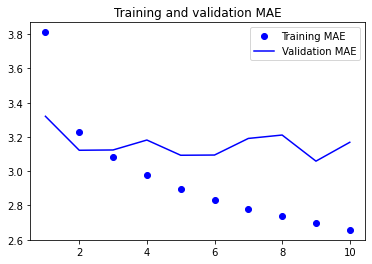

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[과제]LSTM 기반 모델 시도

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 19ms/step - loss: 38.9433 - mae: 4.5268 - val_loss: 11.8981 - val_mae: 2.6414
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 10.5737 - mae: 2.5291 - val_loss: 9.5785 - val_mae: 2.4065
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 9.3824 - mae: 2.3829 - val_loss: 9.5274 - val_mae: 2.4094
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 8.7707 - mae: 2.3083 - val_loss: 9.9822 - val_mae: 2.4550
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 8.3783 - mae: 2.2607 - val_loss: 9.9492 - val_mae: 2.4483
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 8.0888 - mae: 2.2220 - val_loss: 10.0443 - val_mae: 2.4636
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 7.8691 - mae: 2.1934 - val_loss: 11.2678 - val_mae: 2.6155
Epoch 8/10
819/819 [==============================] - 16s

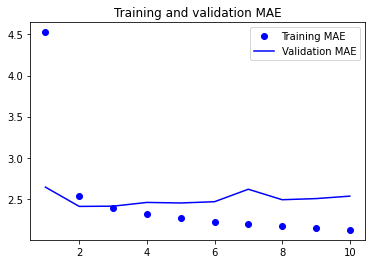

In [26]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[도전과제]RNN 기반 모델 시도(스태킹)

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
# x = layers.SimpleRNN(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_rnn.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_rnn.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 62s 75ms/step - loss: 85.8348 - mae: 7.4871 - val_loss: 65.8538 - val_mae: 6.6795
Epoch 2/10
364/819 [============>.................] - ETA: 29s - loss: 76.7403 - mae: 7.1054

KeyboardInterrupt: ignored

[도전과제]드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 20s 21ms/step - loss: 26.3662 - mae: 3.7897 - val_loss: 10.1525 - val_mae: 2.4930
Epoch 2/50
819/819 [==============================] - 16s 19ms/step - loss: 14.5594 - mae: 2.9622 - val_loss: 9.3709 - val_mae: 2.3955
Epoch 3/50
819/819 [==============================] - 17s 21ms/step - loss: 13.5059 - mae: 2.8494 - val_loss: 9.1499 - val_mae: 2.3664
Epoch 4/50
819/819 [==============================] - 17s 21ms/step - loss: 12.8954 - mae: 2.7838 - val_loss: 9.3121 - val_mae: 2.3821
Epoch 5/50
819/819 [==============================] - 17s 21ms/step - loss: 12.1927 - mae: 2.7088 - val_loss: 9.5268 - val_mae: 2.4039
Epoch 6/50
819/819 [==============================] - 18s 21ms/step - loss: 11.6696 - mae: 2.6508 - val_loss: 10.1122 - val_mae: 2.4844
Epoch 7/50
819/819 [==============================] - 17s 21ms/step - loss: 11.2781 - mae: 2.6017 - val_loss: 9.5379 - val_mae: 2.4081
Epoch 8/50
819/819 [==============================] -

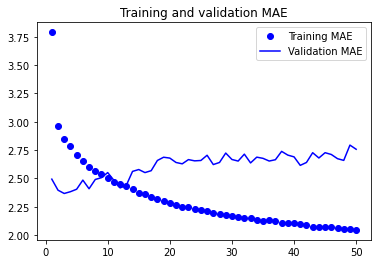

In [29]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[도전과제] 드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가<BR>
GRU 모델은 LSTM을 개선한 모델이다. LSTM보다 파라미터가 더욱 적어 연산 비용도 적고, 모델도 간단해 학습 속도가 더 빠르지만 비슷한 성능을 내는 모델이다

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 24s 26ms/step - loss: 24.9745 - mae: 3.6697 - val_loss: 9.6017 - val_mae: 2.3933
Epoch 2/50
819/819 [==============================] - 21s 25ms/step - loss: 13.3037 - mae: 2.8242 - val_loss: 9.7986 - val_mae: 2.4284
Epoch 3/50
819/819 [==============================] - 21s 26ms/step - loss: 12.5414 - mae: 2.7442 - val_loss: 8.7271 - val_mae: 2.2851
Epoch 4/50
819/819 [==============================] - 21s 26ms/step - loss: 11.8438 - mae: 2.6660 - val_loss: 9.1727 - val_mae: 2.3338
Epoch 5/50
819/819 [==============================] - 21s 26ms/step - loss: 11.2511 - mae: 2.5983 - val_loss: 9.9892 - val_mae: 2.4620
Epoch 6/50
819/819 [==============================] - 20s 24ms/step - loss: 10.7238 - mae: 2.5359 - val_loss: 9.8303 - val_mae: 2.4539
Epoch 7/50
819/819 [==============================] - 21s 26ms/step - loss: 10.1875 - mae: 2.4738 - val_loss: 9.6204 - val_mae: 2.4168
Epoch 8/50
819/819 [==============================] - 2

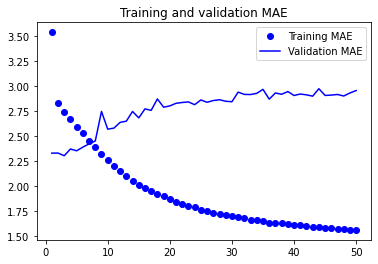

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()